# Canadian House Market Prediction

## Data Loading

In [17]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('datasets/houselistings.csv', encoding='latin1')

""" df['target'] = df['species'].replace({
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}) """

df.head()

,City,Price,Address,Number_Beds,Number_Baths,Province,Population,Latitude,Longitude,Median_Family_Income
0,Toronto,779900.0,#318 -20 SOUTHPORT ST,3,2,Ontario,5647656,43.7417,-79.3733,97000.0
1,Toronto,799999.0,#818 -60 SOUTHPORT ST,3,1,Ontario,5647656,43.7417,-79.3733,97000.0
2,Toronto,799900.0,#714 -859 THE QUEENSWAY,2,2,Ontario,5647656,43.7417,-79.3733,97000.0
3,Toronto,1200000.0,275 MORTIMER AVE,4,2,Ontario,5647656,43.7417,-79.3733,97000.0
4,Toronto,668800.0,#420 -388 RICHMOND ST,1,1,Ontario,5647656,43.7417,-79.3733,97000.0


### Null/Missing values Check

In [18]:
print(df.isnull().sum())

City                    0
Price                   0
Address                 0
Number_Beds             0
Number_Baths            0
Province                0
Population              0
Latitude                0
Longitude               0
Median_Family_Income    0
dtype: int64


### Statistics of Dataset

In [19]:
df.describe()

,Price,Number_Beds,Number_Baths,Population,Latitude,Longitude,Median_Family_Income
count,3.576800e+04,35768.000000,35768.000000,3.576800e+04,35768.000000,35768.000000,35768.000000
mean,9.432963e+05,3.283661,2.532403,6.360151e+05,47.446556,-98.421636,89643.103416
std,1.020110e+06,1.730654,1.371910,1.120016e+06,3.333855,22.280935,12132.353510
min,2.150000e+04,0.000000,0.000000,6.338200e+04,42.283300,-123.936400,62400.000000
25%,4.599000e+05,2.000000,2.000000,1.091670e+05,43.866700,-122.316700,82000.000000
50%,6.990000e+05,3.000000,2.000000,2.424600e+05,49.025000,-104.606700,89000.000000
75%,1.095000e+06,4.000000,3.000000,5.228880e+05,49.888100,-79.866700,97000.000000
max,3.700000e+07,109.000000,59.000000,5.647656e+06,53.916900,63.100500,133000.000000


### Data Preproccessing

First we will drop irrelevant columns. In our case the address is not needed.

In [20]:
df = df.drop(columns=['Address'])

Then we can start to encode any categorical values to unique numerical values. This includes province, and city categories.

In [21]:
city_mapping = {city: idx for idx, city in enumerate(df['City'].unique())}
province_mapping = {province: idx for idx, province in enumerate(df['Province'].unique())}
df['City'] = df['City'].map(city_mapping)
df['Province'] = df['Province'].map(province_mapping)

Now we need to seperate features as well as targets in order to utilize PyTorch. So we complete the following:

In [22]:
# Separate features and target
X = df.drop(columns=['Price'])
y = df['Price']

# Convert to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1) #Reshaping for PyTorch here.


We also should normalize our numeric features because the values range vastly across Canada. This will ensure our data is on similar scales and this could improve our models performance down the line.

In [23]:
mean = X_tensor.mean(dim=0)
std = X_tensor.std(dim=0)
X_tensor = (X_tensor - mean) / std

#Create TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)

Finally we can split the data into training and testing sets, and we can prepare a dataloader. This ensures we can use batching which will also help performance.

In [27]:
# Split into train and test datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data preprocessing complete!")

Data preprocessing complete!


## Visualization & Exploratory Data Analysis

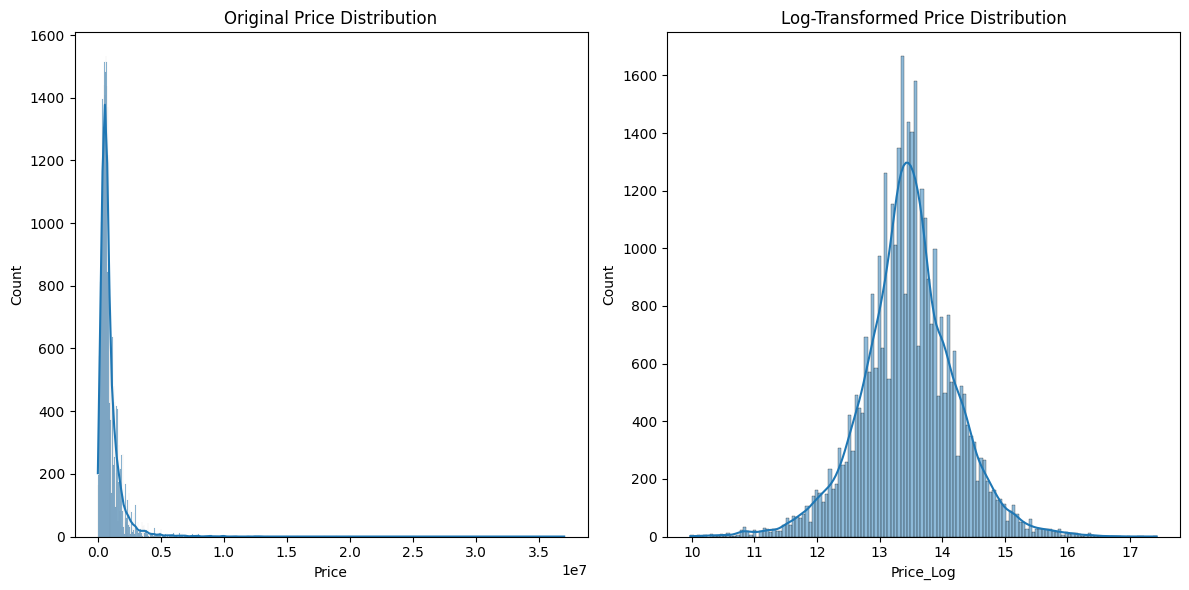

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply log transformation to Price
df['Price_Log'] = np.log1p(df['Price'])  # log1p handles log(1 + x), avoiding log(0)

# Visualize the original and transformed distributions
plt.figure(figsize=(12, 6))

# Original Price Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], kde=True)
plt.title('Original Price Distribution')

# Log-Transformed Price Distribution
plt.subplot(1, 2, 2)
sns.histplot(df['Price_Log'], kde=True)
plt.title('Log-Transformed Price Distribution')

plt.tight_layout()
plt.show()

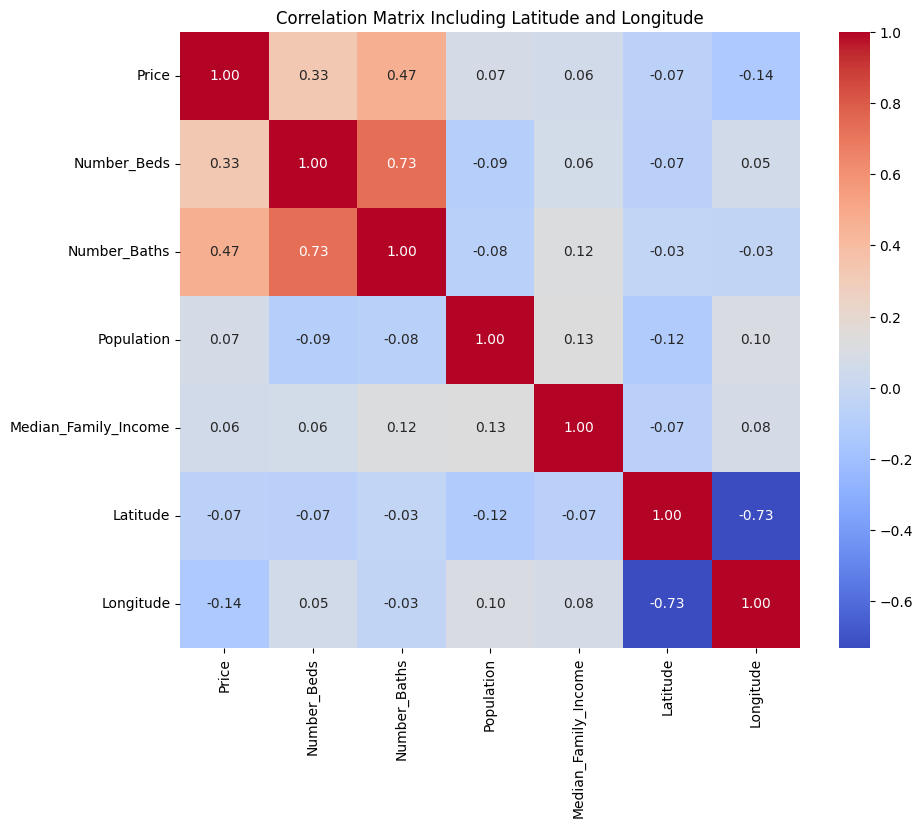

In [30]:
corr_columns = ['Price', 'Number_Beds', 'Number_Baths', 'Population', 
                'Median_Family_Income', 'Latitude', 'Longitude']

corr_matrix = df[corr_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix Including Latitude and Longitude')
plt.show()

In [ ]:
import torch

inputs = torch.tensor(
    df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values,
    dtype=torch.float32
)

targets = torch.tensor(
    df['target'].values,
    dtype=torch.int64
)

In [3]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, shuffle=True, batch_size=4)

In [4]:
torch.manual_seed(4050)
batch0 = next(iter(dataloader))
batch0

[tensor([[6.7000, 3.1000, 4.4000, 1.4000],
         [4.8000, 3.1000, 1.6000, 0.2000],
         [6.7000, 2.5000, 5.8000, 1.8000],
         [4.5000, 2.3000, 1.3000, 0.3000]]),
 tensor([1, 0, 2, 0])]

In [5]:
import torchmetrics

def evaluate(model):
    accuracy = torchmetrics.classification.Accuracy(task='multiclass', num_classes=3)
    x, y_exp = dataset[:]
    y = model(x)
    return accuracy(y, y_exp)

In [6]:
import lightning as L   # torch lightning
import torchinfo        # torch info
from torch import nn    # neural network layers
from torch import optim # optimizers

In [7]:
class LinearClassifier(L.LightningModule):
    def __init__(self):
        super().__init__()
        
        # define the `nn` as the neural network. In this case, it
        # should be a simple nn.Linear(...) layer.
        self.nn = nn.Linear(4, 3)
        
        # define the loss function to be used.
        # It should be nn.CrossEntropyLoss(...)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, batch):
        # return the output which should be
        # a 3D vector corresponding to the logits of the
        # three class predictions.
        return self.nn(batch)
    
    def training_step(self, batch):
        # - The batch is a tuple (x, targets), where
        #   x is the input vectors, and targets the integer labels.
        # - return the loss value for the current batch.
        # - the loss is computed using forward(...) and loss_fn(...)
        x, targets = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, targets)
        return loss
    
    def configure_optimizers(self):
        # returns an optimizer that is configured to
        # optimize `self.parameters()`.
        # Use the optim.Adam(...)
        return optim.Adam(self.parameters(), lr=0.01)

In [8]:
class MLP(LinearClassifier):
    def __init__(self, hidden:int):
        super().__init__()
        self.nn = nn.Sequential(
            # linear layer
            nn.Linear(4, hidden),
            # ReLU
            nn.ReLU(),
            # output linear layer
            nn.Linear(hidden, 3)
        )

In [9]:
torchinfo.summary(MLP(10))

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       50
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       33
├─CrossEntropyLoss: 1-2                  --
Total params: 83
Trainable params: 83
Non-trainable params: 0

In [10]:
torch.manual_seed(0)
model = MLP(10)
trainer = L.Trainer(max_epochs=10)

trainer.fit(model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | nn      | Sequential       | 83     | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
83        Trainable params
0         Non-trainable params
83        Total params
0.000     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 38/38 [00:00<00:00, 400.00it/s, v_num=7]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 38/38 [00:00<00:00, 376.24it/s, v_num=7]


In [11]:
evaluate(model)

tensor(0.9533)

In [12]:
import onnx

model.eval()
torch.onnx.export(
    model,
    torch.randn(1, 4),
    "../deploy/my_model.onnx",
    export_params=True,
    opset_version=11,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)